In [532]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import requests
import json
import csv
import math
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statistics

# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import requests
import json
import csv
import math
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statistics

# Importing sector, price, financials, & market data

In [533]:
# Get the organCode from list of all tickers
def process(filename:str="/Users/nambuismbp/projects/investment_research/data/codedict.txt") -> dict:
    ticker_to_organ_code = {}
    with open(filename, "r") as json_file:
        data = json.load(json_file)
        ticker_to_organ_code = {
            item["ticker"]: item["organCode"] for item in data["items"]}
        return ticker_to_organ_code
    return None

ticker_dict = process()

# Get ticker from the organCode
def get_ticker(val):
    for key, value in ticker_dict.items():
        if val == value:
            return key

In [534]:
# Load in sector data
dfSectorInfo = pd.read_csv(r'/Users/nambuismbp/projects/investment_research/data/descriptive_info.csv')

In [535]:
# Load in pricing data
dfPricingInfo = pd.read_csv(r'/Users/nambuismbp/projects/investment_research/data/pricing_data.csv')

# Uniform column name to be ticker
for col in dfPricingInfo:
    dfPricingInfo.rename(columns = {col: get_ticker(col)}, inplace = True)

# Create new monthly date series and insert into dataframe
monthSeries = pd.date_range('2008-01-31', periods=len(dfPricingInfo), freq='M')
count = 0
for date in reversed(range(len(monthSeries))):
    dfPricingInfo.at[count, 'date'] = monthSeries[date]
    count = count + 1

# Rearrange columns so that date appears first
del dfPricingInfo[dfPricingInfo.columns[0]]
cols = dfPricingInfo.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfPricingInfo = dfPricingInfo[cols]

In [536]:
# Load in trading value data
dfTradingVal = pd.read_csv(r'/Users/nambuismbp/projects/investment_research/data/trading_value_data.csv')

# Put trading value data having the same dates as pricing data
del dfTradingVal[dfTradingVal.columns[0]]
extracted = dfPricingInfo['date'].to_list()
dfTradingVal.insert(0, "date", extracted)

# Uniform column name to be ticker
for col in dfTradingVal:
    if col != 'date': dfTradingVal.rename(columns = {col: get_ticker(col)}, inplace = True)

In [537]:
# Load in financial data
with open("/Users/nambuismbp/projects/investment_research/data/financial_data_dec29.txt", 'r') as file:
    financials_raw = json.load(file)

financials={}
for (key, value) in financials_raw.items():
    ticker = get_ticker(key)
    financials[ticker] = value

In [538]:
# Load in market return
dfMarketReturn = pd.read_csv(r'/Users/nambuismbp/projects/investment_research/data/market_return.csv')
monthSeries = pd.date_range('2000-07-31', periods=len(dfMarketReturn), freq='M')
count = 0
for date in reversed(range(len(monthSeries))):
    dfMarketReturn.at[count, 'date'] = monthSeries[date]
    count = count + 1

# Scale up returns to match display format of stock & portfolios
dfMarketReturn['market_return'] = dfMarketReturn['market_return'].multiply(100)

# Functions to select the right universe based on data availability & liquidity


In [539]:
# Select only companies that has all 4 quarters of financial data in the previous year
def check_financial_data(date, data) -> list:
    financialScreeningList = []
    for ticker in data:
        count = data[ticker]['years'].count(date.year - 1)
        if count == 4: financialScreeningList.append(ticker)
    return financialScreeningList

In [540]:
# Select only companies that have pricing data in the month
def check_pricing_data(date, data) -> list:
    priceScreeningList = []
    index = data[data['date'] == datetime(date.year, date.month, date.day)].index[0]
    for ticker in dfPricingInfo:
        if ticker != 'date' and not math.isnan(dfPricingInfo.loc[index, ticker]):
            priceScreeningList.append(ticker)
    return priceScreeningList

In [541]:
# Select only companies that are not banks, insurance or financial services
def check_sector_data(dataframe) -> list:
    dataRemove = dataframe[dataframe['ICB_Sector_L2'] != 'Dịch vụ tài chính L2']
    dataRemove = dataRemove[dataRemove['ICB_Sector_L2'] != 'Ngân hàng L2']
    dataRemove = dataRemove[dataRemove['ICB_Sector_L2'] != 'Bảo hiểm L2']
    
    sectorScreeningList = dataRemove['Ticker'].to_list()
    return sectorScreeningList

# Functions to rank and sort stocks by factors


In [542]:
def get_marketcap(date, tickers, financials) -> dict:
    quarter = (date.month-1)//3 + 1
    sizeFactorDict = {}
    for ticker in tickers:
        # Getting current Market Cap
        currDateIndex = 0
        currNumShare = 0
        numShare = 0
        marketCap = 0
        for i in range(len(financials[ticker]['years'])):
            if financials[ticker]['years'][i] == date.year and financials[ticker]['quarters'][i] == quarter:
                currDateIndex = i
        if currDateIndex != 0:
            numShare = financials[ticker]['num_share'][currDateIndex]
        
        currPriceIndex = dfPricingInfo[dfPricingInfo['date'] == date].index[0]
        currPrice = dfPricingInfo.loc[currPriceIndex, ticker]
        
        if numShare != 0 and currPrice != 0 and not np.isnan(currPrice) and not np.isnan(numShare):
            marketCap = numShare * currPrice
            sizeFactorDict[ticker] = marketCap
    return sizeFactorDict


In [543]:
def get_size(date, tickers, financials) -> dict:
    quarter = (date.month-1)//3 + 1
    sizeFactorDict = {}
    for ticker in tickers:
        # Getting current Market Cap
        currDateIndex = 0
        currNumShare = 0
        numShare = 0
        marketCap = 0
        for i in range(len(financials[ticker]['years'])):
            if financials[ticker]['years'][i] == date.year and financials[ticker]['quarters'][i] == quarter:
                currDateIndex = i
        if currDateIndex != 0:
            numShare = financials[ticker]['num_share'][currDateIndex]
        
        currPriceIndex = dfPricingInfo[dfPricingInfo['date'] == date].index[0]
        currPrice = dfPricingInfo.loc[currPriceIndex, ticker]
        
        if numShare != 0 and currPrice != 0 and not np.isnan(currPrice) and not np.isnan(numShare):
            marketCap = numShare * currPrice
            sizeFactorDict[ticker] = math.log(marketCap)
    return sizeFactorDict


In [544]:
# Value factor = Book Value of Last Accounting Year / Current Market Cap
def get_value(date, tickers, financials) -> dict:
    quarter = (date.month-1)//3 + 1
    valueFactorDict = {}
    for ticker in tickers:
        # Getting current Market Cap
        currDateIndex = 0
        currNumShare = 0
        numShare = 0
        marketCap = 0
        for i in range(len(financials[ticker]['years'])):
            if financials[ticker]['years'][i] == date.year and financials[ticker]['quarters'][i] == quarter:
                currDateIndex = i
        if currDateIndex != 0:
            numShare = financials[ticker]['num_share'][currDateIndex]
        
        currPriceIndex = dfPricingInfo[dfPricingInfo['date'] == date].index[0]
        currPrice = dfPricingInfo.loc[currPriceIndex, ticker]
        
        if numShare != 0 and currPrice != 0 and not np.isnan(currPrice) and not np.isnan(numShare):
            marketCap = numShare * currPrice
        
        # Getting last year book value
        bookValue = 0
        lastYearIndex = 0
        for i in range(len(financials[ticker]['years'])):
            if financials[ticker]['years'][i] == date.year-1 and financials[ticker]['quarters'][i] == 4:
                lastYearIndex = i
        if lastYearIndex != 0:
            result = financials[ticker]['total_equity'][lastYearIndex]
            if result is not None:
                bookValue = result
        
        # Calculate BE / ME only if the firm does not have negative book value
        if marketCap != 0 and bookValue > 0:
            valueFactorDict[ticker] = math.log(bookValue / marketCap)
    return valueFactorDict     

# Functions to create quintile portfolios and calculate returns

In [545]:
def create_decile_portfolios(sortedDict, decile) -> list:
    keys = pd.Series(list(sortedDict.keys()))
    values = pd.Series(list(sortedDict.values()))
    df = pd.DataFrame({'ticker': keys, 'values': values})
    df['decile_rank'] = pd.qcut(df['values'], numPortfolio, labels = False)
    
    idx = df.index[df['decile_rank'] == decile].tolist()
    decileList = df['ticker'][idx].tolist()
    return decileList

In [546]:
def diff_month(d1, d2) -> int:
    return (d2.year - d1.year) * 12 + d2.month - d1.month

#Function to calculate average monthly return of a stock in month beginmonth + 1
def get_stock_monthly_return(stock, beginmonth) -> float:
    index = dfPricingInfo.index[dfPricingInfo['date'] == beginmonth]
    
    beginPrice = dfPricingInfo.iloc[index][stock].iat[0]
    endPrice = dfPricingInfo.iloc[index-1][stock].iat[0]
    
    monthlyReturn = (endPrice / beginPrice - 1) * 100
    return monthlyReturn

In [547]:
# Equal-weighted average returns of stocks in portfolio
def get_portfolio_monthly_return_EW(portfolio, beginPeriod, endPeriod) -> float:
    monthSeries = pd.date_range(start=beginPeriod, end=endPeriod, freq = 'M')
    portfolioMonthlyReturn = []
    
    for month in monthSeries:
        if month == endPeriod:
            break
        temp = []
        for stock in portfolio:
            temp.append(get_stock_monthly_return(stock, month))
        average = sum(temp) / len(temp)
        portfolioMonthlyReturn.append(average)
                    
    return portfolioMonthlyReturn

In [548]:
# Value-weighted (by market cap) average returns of stocks in portfolio
def get_portfolio_monthly_return_VW(portfolio, beginPeriod, endPeriod) -> float:
    monthSeries = pd.date_range(start=beginPeriod, end=endPeriod, freq = 'M')
    portfolioMonthlyReturn = []
    
    for month in monthSeries:
        if month == endPeriod:
            break
        stockretList = []
        marketcapList = []
        
        size = get_marketcap(month, portfolio, financials)
        
        for stock in portfolio:
            if stock in size:
                stockretList.append(get_stock_monthly_return(stock, month))
                marketcapList.append(size[stock])
        
        weights = []
        for stock in marketcapList:
            weights.append(stock / sum(marketcapList))
        
        weightedavg = sum(ret * weights for ret, weights in zip(stockretList, weights))
        portfolioMonthlyReturn.append(weightedavg)
        
    return portfolioMonthlyReturn

In [549]:
def get_stock_monthly_trading_val(stock, beginmonth) -> float:
    index = dfTradingVal.index[dfTradingVal['date'] == beginmonth]
    tradingVal = dfTradingVal.iloc[index-1][stock].iat[0]
    return tradingVal

In [550]:
def get_portfolio_yearly_avg_trading_val(portfolio, beginPeriod, endPeriod) -> float:
    monthSeries = pd.date_range(start=beginPeriod, end=endPeriod, freq = 'M')
    portfolioTradingVal = []
    
    for month in monthSeries:
        if month == endPeriod:
            break
        temp = []
        for stock in portfolio:
            temp.append(get_stock_monthly_trading_val(stock, month))
        average = sum(temp) / len(temp)
        portfolioTradingVal.append(average)
    return sum(portfolioTradingVal) / len(portfolioTradingVal)

# Functions to get beta & standard deviation

In [551]:
def get_portfolio_beta(portfolioReturns, market_data) -> list:
    betaList = []
    monthlyRet = []
    marketRet = []
    
    #Calculate beta
    for portfolio in range(numPortfolio):
        tempList = []
        for year in portfolioReturns:
            tempList.extend(portfolioReturns[year][portfolio])
        monthlyRet.append(tempList)

    t = beginDate
    for period in range(len(yearSeries)):
        index = dfMarketReturn[dfMarketReturn['date'] == t].index[0]
        index = index - 1
        for i in range(12):
            marketRet.append(dfMarketReturn.loc[index, 'market_return'])
            index = index - 1 
        t = t.replace(year = t.year + 1)
    
    for i in range(len(monthlyRet)):
        dfMonthlyRet = pd.Series(monthlyRet[i])
        dfMarketRet = pd.Series(marketRet)
        covar = dfMonthlyRet.cov(dfMarketRet)
        var = dfMarketRet.var()
        beta = round(covar / var, 3)
        betaList.append(beta)
    return betaList

In [552]:
get_portfolio_std(portfolioReturnsVW)

[5.939, 6.3, 7.711, 8.212, 8.727]

In [553]:
def get_portfolio_std(portfolioReturns) -> list:
    monthlyRet = []
    stdList = []
    for portfolio in range(numPortfolio):
        tempList = []
        for year in portfolioReturns:
            tempList.extend(portfolioReturns[year][portfolio])
        monthlyRet.append(tempList)
    for i in range(len(monthlyRet)):
        dfMonthlyRet = pd.Series(monthlyRet[i])
        stdList.append(round(dfMonthlyRet.std(), 3))
    return stdList

# Set parameters for the model

In [554]:
# Set begin and end dates for backtesting
beginDate = datetime(2012, 6, 30)
endDate = datetime(2022, 6, 30)

# Set number of portfolios
numPortfolio = 10

# Set liquidity restriction by value
minLiquidity = 50000000

# Running model

In [555]:
# Generate date series for the backtesting
yearSeries = pd.date_range(start=beginDate, end=endDate, freq = 'Y')

In [556]:
# Get the universe of acceptable stocks for each year
date = beginDate
universe = {}
for year in yearSeries:
    accountingYear = date - relativedelta(years=1)
    financialScreeningList = check_financial_data(accountingYear, financials)
    priceScreeningList = check_pricing_data(date, dfPricingInfo)
    sectorScreeningList = check_sector_data(dfSectorInfo)
    universe[year] = list(set(sectorScreeningList) & set(priceScreeningList) & set(financialScreeningList))    
    
    print(f'In yearly period from {date.year} to {date.year + 1} the investable unvierse has {len(universe[year])} stocks')
    date = date.replace(year = date.year + 1)

In yearly period from 2012 to 2013 the investable unvierse has 190 stocks
In yearly period from 2013 to 2014 the investable unvierse has 219 stocks
In yearly period from 2014 to 2015 the investable unvierse has 232 stocks
In yearly period from 2015 to 2016 the investable unvierse has 245 stocks
In yearly period from 2016 to 2017 the investable unvierse has 251 stocks
In yearly period from 2017 to 2018 the investable unvierse has 272 stocks
In yearly period from 2018 to 2019 the investable unvierse has 289 stocks
In yearly period from 2019 to 2020 the investable unvierse has 307 stocks
In yearly period from 2020 to 2021 the investable unvierse has 329 stocks
In yearly period from 2021 to 2022 the investable unvierse has 344 stocks


In [557]:
# Get the decile portfolios based on ranking factor for each year
portfolios = {}

for year in yearSeries:
    keys = universe[year]
    # Get a dictionary of the factors for each stock
    sizefactor = get_size(datetime(year.year, beginDate.month, beginDate.day), keys, financials)
    valuefator = get_value(datetime(year.year, beginDate.month, beginDate.day), keys, financials)
    
    # Remove stocks from the ranking list if they are not in the universe
    sizefactor = {key:val for key, val in sizefactor.items() if key in universe[year]}
    valuefactor = {key:val for key, val in valuefator.items() if key in universe[year]}
    
    # Remove stocks that do not meet liquidity restriction of more than 10 million VND per day
    liquidityScreening = []
    for stock in keys:
        yearlyLiquidity = []
        for month in range(12):
            yearlyLiquidity.append(get_stock_monthly_trading_val(stock, datetime(year.year, beginDate.month, beginDate.day)))
        avgMonthlyLiquidity = (sum(yearlyLiquidity) / len(yearlyLiquidity)) / 12
        avgDailyLiquidity = avgMonthlyLiquidity / 21
        if avgDailyLiquidity > minLiquidity:
            liquidityScreening.append(stock)
            
    # Remove stocks from the ranking list if they do not meet liquidity restrictions
    sizefactor = {key:val for key, val in sizefactor.items() if key in liquidityScreening}
    valuefactor = {key:val for key, val in valuefactor.items() if key in liquidityScreening}
    
    # Sort based on factor
    sizefactorSorted = dict(sorted(sizefactor.items(), key=lambda item: item[1], reverse = True))
    valuefactorSorted = dict(sorted(valuefactor.items(), key=lambda item: item[1], reverse = False))

    # Combine the ranking and create the common factor
    commonKeys = list(set(sizefactorSorted.keys()) & set(valuefactorSorted.keys()))
    combinedfactor = {}
    for ticker in commonKeys:
        combinedfactor[ticker] = list(sizefactorSorted).index(ticker) + list(valuefactorSorted).index(ticker)
    
    combinedfactorSorted = dict(sorted(combinedfactor.items(), key=lambda item: item[1], reverse = False))
    
    # List of decile portfolios in a given year
    portfolioList = []
    countStock = []
    for decile in range(numPortfolio):
        getPortfolio = create_decile_portfolios(combinedfactorSorted, decile)
        portfolioList.append(getPortfolio)
        countStock.extend(getPortfolio)
        
        avgScore = []
        
        # Print out average BE/ME for each decile in the year
        for item in getPortfolio:
            avgScore.append(combinedfactor[item])
        print(f"The average score in year {year.year} for portfolio decile {decile + 1} is {round(sum(avgScore)/len(avgScore), 3)}")
        #print(f"Number of companies in year {year.year} for portfolio decile {decile + 1} is {len(getPortfolio)}")        

    print(f"In the period between {year.year} and {year.year + 1}, there are {len(countStock)} companies in total with an average of {len(countStock)/numPortfolio} in each portfolio")
    portfolios[year] = portfolioList

The average score in year 2012 for portfolio decile 1 is 10.125
The average score in year 2012 for portfolio decile 2 is 31.875
The average score in year 2012 for portfolio decile 3 is 41.875
The average score in year 2012 for portfolio decile 4 is 56.125
The average score in year 2012 for portfolio decile 5 is 72.25
The average score in year 2012 for portfolio decile 6 is 86.714
The average score in year 2012 for portfolio decile 7 is 99.556
The average score in year 2012 for portfolio decile 8 is 114.0
The average score in year 2012 for portfolio decile 9 is 124.125
The average score in year 2012 for portfolio decile 10 is 146.25
In the period between 2012 and 2013, there are 79 companies in total with an average of 7.9 in each portfolio
The average score in year 2013 for portfolio decile 1 is 11.556
The average score in year 2013 for portfolio decile 2 is 28.625
The average score in year 2013 for portfolio decile 3 is 45.444
The average score in year 2013 for portfolio decile 4 is 6

In [558]:
# Examine the average trading value for each decile portfolio in a given year
for year in yearSeries:
    beginPeriod = datetime(year.year, beginDate.month, beginDate.day)
    endPeriod = datetime(year.year+1, beginDate.month-1, beginDate.day)
    for decile in range(numPortfolio):
        myport = portfolios[year][decile]
        portfolioTradingVal = get_portfolio_yearly_avg_trading_val(myport, beginPeriod, endPeriod)
        stockDailyTradingVal = (portfolioTradingVal / 21) / len(myport)
        print(f"From year {year.year} to {year.year+1}, the average daily trading value for a stock in portfolio decile {decile+1} was {round(stockDailyTradingVal, 0):,}")

From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 1 was 2,284,613,314.0
From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 2 was 1,356,829,699.0
From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 3 was 779,039,595.0
From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 4 was 792,763,508.0
From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 5 was 467,920,559.0
From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 6 was 528,010,467.0
From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 7 was 394,063,610.0
From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 8 was 218,178,145.0
From year 2012 to 2013, the average daily trading value for a stock in portfolio decile 9 was 396,280,079.0
From year 2012 to 2013, 

From year 2019 to 2020, the average daily trading value for a stock in portfolio decile 8 was 266,454,750.0
From year 2019 to 2020, the average daily trading value for a stock in portfolio decile 9 was 232,796,219.0
From year 2019 to 2020, the average daily trading value for a stock in portfolio decile 10 was 240,202,510.0
From year 2020 to 2021, the average daily trading value for a stock in portfolio decile 1 was 5,452,669,482.0
From year 2020 to 2021, the average daily trading value for a stock in portfolio decile 2 was 3,027,016,291.0
From year 2020 to 2021, the average daily trading value for a stock in portfolio decile 3 was 4,026,915,136.0
From year 2020 to 2021, the average daily trading value for a stock in portfolio decile 4 was 2,429,250,970.0
From year 2020 to 2021, the average daily trading value for a stock in portfolio decile 5 was 2,198,917,684.0
From year 2020 to 2021, the average daily trading value for a stock in portfolio decile 6 was 1,269,785,013.0
From year 2020 

# Equal weighted portfolios

In [559]:
# Get equal weighted monthly returns for each portfolio for each year
date = beginDate

portfolioReturnsEW = {}
for year in yearSeries: # go inside year, having access to all portfolios
    nextYear = date.replace(year = date.year + 1)
    returnsInYear = []

    for i in range(len(portfolios[year])): # go inside to get monthly returns of individual portfolio
        temp = get_portfolio_monthly_return_EW(portfolios[year][i], date, nextYear)
        returnsInYear.append(temp)
    portfolioReturnsEW[year] = returnsInYear
    
    # Move to next year
    date = nextYear

In [560]:
# Calculate average returns of all months during testing period for decile portfolios
avgMonthlyPortfolioReturnsEW = []

for i in range(numPortfolio):
    allYearsAvg = []
    for year in portfolioReturnsEW:
        oneYearAvg = sum(portfolioReturnsEW[year][i]) / len(portfolioReturnsEW[year][i])
        allYearsAvg.append(oneYearAvg)
        print(f"In year {year.year}, portfolio decile {i+1} has an average monthly return of {round(oneYearAvg, 3)} percent")
    
    avgMonthlyPortfolioReturnsEW.append(sum(allYearsAvg) / len(allYearsAvg))

In year 2012, portfolio decile 1 has an average monthly return of 0.919 percent
In year 2013, portfolio decile 1 has an average monthly return of 0.979 percent
In year 2014, portfolio decile 1 has an average monthly return of 0.021 percent
In year 2015, portfolio decile 1 has an average monthly return of 0.399 percent
In year 2016, portfolio decile 1 has an average monthly return of 0.351 percent
In year 2017, portfolio decile 1 has an average monthly return of 0.622 percent
In year 2018, portfolio decile 1 has an average monthly return of 0.108 percent
In year 2019, portfolio decile 1 has an average monthly return of -1.303 percent
In year 2020, portfolio decile 1 has an average monthly return of 2.94 percent
In year 2021, portfolio decile 1 has an average monthly return of -0.838 percent
In year 2012, portfolio decile 2 has an average monthly return of 1.342 percent
In year 2013, portfolio decile 2 has an average monthly return of 2.653 percent
In year 2014, portfolio decile 2 has an

In [561]:
avgMonthlyPortfolioBetaEW = get_portfolio_beta(portfolioReturnsEW, dfMarketReturn)
avgMonthlyPortfolioStdEW = get_portfolio_std(portfolioReturnsEW)

In [570]:
names = []
for portfolio in range(numPortfolio):
    names.append(f"Decile {str(portfolio+1)}")

dfReturns = pd.DataFrame({'Value Factor': names, 'Avg Monthly Return': avgMonthlyPortfolioReturnsEW, 'Annualized Stdev': avgMonthlyPortfolioStdEW})
print("Average monthly returns of equal weighted portfolios")
print(dfReturns)

Average monthly returns of equal weighted portfolios
  Value Factor  Avg Monthly Return  Annualized Stdev
0     Decile 1            0.419918             5.734
1     Decile 2            0.695042             6.824
2     Decile 3            1.342109             6.001
3     Decile 4            1.405339             5.612
4     Decile 5            1.539733             7.275
5     Decile 6            1.221345             7.384
6     Decile 7            1.877476             7.655
7     Decile 8            2.164202             7.524
8     Decile 9            2.104187             8.672
9    Decile 10            3.739037             8.915


# Value weighted portfolios

In [563]:
# Get value weighted monthly returns for each portfolio for each year
date = beginDate

portfolioReturnsVW = {}
for year in yearSeries: # go inside year, having access to all portfolios
    nextYear = date.replace(year = date.year + 1)
    returnsInYear = []

    for i in range(len(portfolios[year])): # go inside to get monthly returns of individual portfolio
        temp = get_portfolio_monthly_return_VW(portfolios[year][i], date, nextYear)
        returnsInYear.append(temp)
    portfolioReturnsVW[year] = returnsInYear
    
    # Move to next year
    date = nextYear

In [564]:
# Calculate average returns of all months during testing period for decile portfolios
avgMonthlyPortfolioReturnsVW = []

for i in range(numPortfolio):
    allYearsAvg = []
    for year in portfolioReturnsVW:
        oneYearAvg = sum(portfolioReturnsVW[year][i]) / len(portfolioReturnsVW[year][i])
        allYearsAvg.append(oneYearAvg)
        print(f"In year {year.year}, portfolio quantile {i+1} has an average monthly return of {round(oneYearAvg, 3)} percent")
    
    avgMonthlyPortfolioReturnsVW.append(sum(allYearsAvg) / len(allYearsAvg))

In year 2012, portfolio quantile 1 has an average monthly return of 1.078 percent
In year 2013, portfolio quantile 1 has an average monthly return of 0.368 percent
In year 2014, portfolio quantile 1 has an average monthly return of -1.592 percent
In year 2015, portfolio quantile 1 has an average monthly return of 1.146 percent
In year 2016, portfolio quantile 1 has an average monthly return of 1.105 percent
In year 2017, portfolio quantile 1 has an average monthly return of 3.165 percent
In year 2018, portfolio quantile 1 has an average monthly return of 0.407 percent
In year 2019, portfolio quantile 1 has an average monthly return of -1.863 percent
In year 2020, portfolio quantile 1 has an average monthly return of 2.684 percent
In year 2021, portfolio quantile 1 has an average monthly return of -1.367 percent
In year 2012, portfolio quantile 2 has an average monthly return of 1.508 percent
In year 2013, portfolio quantile 2 has an average monthly return of 3.054 percent
In year 2014,

In [565]:
avgMonthlyPortfolioBetaVW = get_portfolio_beta(portfolioReturnsVW, dfMarketReturn)
avgMonthlyPortfolioStdVW = get_portfolio_std(portfolioReturnsVW)

In [566]:
names = []
for portfolio in range(numPortfolio):
    names.append(f"Decile {str(portfolio + 1)}")

dfReturns = pd.DataFrame({'Value Factor': names, 'Avg Monthly Return': avgMonthlyPortfolioReturnsVW, 'Annualized Stdev': avgMonthlyPortfolioStdVW})
print("Average monthly returns of value weighted portfolios")
print(dfReturns)

Average monthly returns of value weighted portfolios
  Value Factor  Avg Monthly Return  Annualized Stdev
0     Decile 1            0.513265             5.963
1     Decile 2            1.071912             7.313
2     Decile 3            1.879150             6.713
3     Decile 4            1.434822             6.602
4     Decile 5            1.346501             7.948
5     Decile 6            1.349996             8.254
6     Decile 7            2.493995             8.799
7     Decile 8            2.392678             8.275
8     Decile 9            1.837427             9.150
9    Decile 10            3.494322             9.126


# Print out the returns


In [567]:
names = []
for portfolio in range(numPortfolio):
    names.append(f"Decile {str(portfolio + 1)}")

dfReturnsEW = pd.DataFrame({'Value Factor': names, 'Avg Monthly Return': avgMonthlyPortfolioReturnsEW, 'Stdev': avgMonthlyPortfolioStdEW})
print("Average monthly returns of equal weighted portfolios for combined SIZE & VALUE factor")
print(dfReturnsEW)
print()

dfReturnsVW = pd.DataFrame({'Value Factor': names, 'Avg Monthly Return': avgMonthlyPortfolioReturnsVW, 'Stdev': avgMonthlyPortfolioStdVW})
print("Average monthly returns of value weighted portfolios for combined SIZE & VALUE factor")
print(dfReturnsVW)

Average monthly returns of equal weighted portfolios for combined SIZE & VALUE factor
  Value Factor  Avg Monthly Return  Stdev
0     Decile 1            0.419918  5.734
1     Decile 2            0.695042  6.824
2     Decile 3            1.342109  6.001
3     Decile 4            1.405339  5.612
4     Decile 5            1.539733  7.275
5     Decile 6            1.221345  7.384
6     Decile 7            1.877476  7.655
7     Decile 8            2.164202  7.524
8     Decile 9            2.104187  8.672
9    Decile 10            3.739037  8.915

Average monthly returns of value weighted portfolios for combined SIZE & VALUE factor
  Value Factor  Avg Monthly Return  Stdev
0     Decile 1            0.513265  5.963
1     Decile 2            1.071912  7.313
2     Decile 3            1.879150  6.713
3     Decile 4            1.434822  6.602
4     Decile 5            1.346501  7.948
5     Decile 6            1.349996  8.254
6     Decile 7            2.493995  8.799
7     Decile 8            2.3

In [571]:
# Cumulative returns of value weighted portfolio
dfCumReturns = pd.DataFrame()
for portfolio in range(numPortfolio):
    data = []
    for year in portfolioReturnsVW: 
        for month in portfolioReturnsVW[year][portfolio]:
            data.append(month)
    dfMonthlyReturns["Portfolio " + str(portfolio + 1)] = pd.Series(data)
        
    marketMonthlyReturn = []
    t = beginDate
    for period in range(len(yearSeries)):
        index = dfMarketReturn[dfMarketReturn['date'] == t].index[0]
        index = index - 1
        for i in range(12):
            marketMonthlyReturn.append(dfMarketReturn.loc[index, 'market_return'])
            index = index - 1 
        t = t.replace(year = t.year + 1)
        
    cumReturn = []
    cumReturnMarket = []
        
    totalReturn = 100
    totalMarketReturn = 100
    for i in range(len(data)):
        totalReturn = math.ceil(totalReturn * (1 + data[i]/100))
        totalMarketReturn = math.ceil(totalMarketReturn * (1 + marketMonthlyReturn[i]/100))
        cumReturn.append(totalReturn)
        cumReturnMarket.append(totalMarketReturn)
        
    dfCumReturns["Decile " + str(portfolio + 1)] = pd.Series(cumReturn)
dfCumReturns["VNIndex"] = pd.Series(cumReturnMarket)

dfCumReturns['months'] = pd.date_range(start=beginDate.replace(month = beginDate.month + 1), end=endDate, freq = 'M')
dfCumReturns = dfCumReturns.set_index('months')
print(dfCumReturns)

            Decile 1  Decile 2  Decile 3  Decile 4  Decile 5  Decile 6  \
months                                                                   
2012-07-31        98        98        98        97        99        99   
2012-08-31        98        93        87        94        91        88   
2012-09-30        98        86        81        87        81        83   
2012-10-31        97        88        79        93        82        83   
2012-11-30        93        84        76       104        81        84   
...              ...       ...       ...       ...       ...       ...   
2022-02-28       250       427      1058       733       656       699   
2022-03-31       248       456      1128       740       666       735   
2022-04-30       235       404      1041       624       576       594   
2022-05-31       230       387      1013       590       511       543   
2022-06-30       217       370       956       547       473       456   

            Decile 7  Decile 8  Decil

<AxesSubplot:title={'center':'Cumulative Returns from 30 June 2012 to 30 June 2022, indexed to $100 original investment'}, xlabel='Years', ylabel='Portfolio Value'>

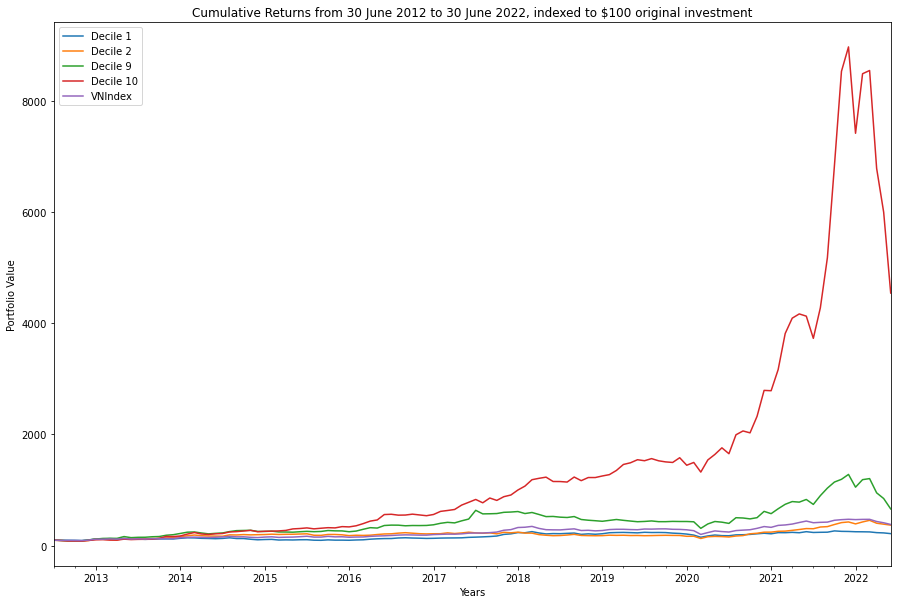

In [574]:
dfCumReturns.plot(y=["Decile 1","Decile 2", "Decile 9", "Decile 10", "VNIndex"],
                  kind="line", figsize=(15, 10),
                  ylabel = "Portfolio Value",
                  xlabel = "Years",
                  title = "Cumulative Returns from 30 June 2012 to 30 June 2022, indexed to $100 original investment")